In [1]:
from sunpy.net import Fido, attrs as a
import astropy.units as u
import astropy.time
import astropy.io.fits
from sunpy.coordinates import propagate_with_solar_surface
from reproject import reproject_adaptive
import astropy.wcs
import ndcube
from sunpy.map.header_helper import make_fitswcs_header
import sunpy.map
import eispac.core
import numpy as np
from aiapy.calibrate.util import get_correction_table

import dask.array
import distributed
from dask_gateway import Gateway
from dask.distributed import PipInstall

import sys
sys.path.append('../pipeline')
from net.heliocloud import HelioCloudClient
import net.attrs as heliocloud_attrs
from stack_aia_data import build_cutout_cube

In [2]:
import distributed

In [3]:
client = distributed.Client()

In [4]:
client.dashboard_link

'http://127.0.0.1:8787/status'

In [5]:
client.scheduler.address

'tcp://127.0.0.1:46845'

## Dask Client Setup

In [2]:
gateway = Gateway()

In [3]:
options = gateway.cluster_options()
options.worker_cores = 1
options.worker_memory = 8

In [4]:
cluster = gateway.new_cluster(options)

In [5]:
client = cluster.get_client()
client

/home/jovyan/users_conda_envs/hinode-2023-loops-poster/lib/python3.11/site-packages/distributed/client.py:1361: VersionMismatchWarning: Mismatched versions found

+---------+----------------+----------------+---------+
| Package | Client         | Scheduler      | Workers |
+---------+----------------+----------------+---------+
| python  | 3.11.4.final.0 | 3.10.8.final.0 | None    |
+---------+----------------+----------------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/daskhub.1fd56d5a209b442dad84f6f6f29805e8/status,


In [6]:
pip_plugin = PipInstall(
    packages=[
        "ndcube",
        "sunpy[map]",
        "astropy",
        "aiapy",
    ],
    pip_options=["--upgrade"],
)
client.register_worker_plugin(pip_plugin)

{}

In [7]:
cluster.adapt(minimum=3, maximum=100)

In [15]:
client.scheduler.address

'gateway://traefik-daskhub-dask-gateway.daskhub:80/daskhub.1fd56d5a209b442dad84f6f6f29805e8'

In [19]:
client.cluster.scheduler_address

'gateway://traefik-daskhub-dask-gateway.daskhub:80/daskhub.1fd56d5a209b442dad84f6f6f29805e8'

## Align AIA Data

In [5]:
interval = 12*u.h
time_start = astropy.time.Time('2012-09-24 09:00:00', scale='utc', format='iso')
time_end = time_start + interval

To search for data, we can use the `Fido` search interface provided by `sunpy` combined with a custom client developed to search the HelioCloud database.

In [6]:
q = Fido.search(
    a.Time(time_start, time_end),
    a.Wavelength(171*u.angstrom),
    heliocloud_attrs.Dataset('AIA'),
)

In [7]:
m_eis_ref = sunpy.map.Map('../pipeline/data/EIS/level_2.5/*.fe_12_195_119.2c-0.int.fits')

In [8]:
aia_scale = [0.6,  0.6]* u.arcsec / u.pix
shape = np.ceil(u.Quantity(m_eis_ref.dimensions) * u.Quantity(m_eis_ref.scale) / aia_scale).to_value('pix').astype(int)[::-1]

In [9]:
wavelength = 171 * u.AA

In [10]:
ref_header = make_fitswcs_header(tuple(shape),
                                 m_eis_ref.center,
                                 scale=aia_scale,
                                 rotation_angle=0*u.deg,
                                 wavelength=wavelength,
                                 instrument='AIA',
                                 telescope='SDO/AIA',
                                 observatory='SDO',
                                 detector='AIA')

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


In [11]:
cadence = 4 * u.minute
time_common = time_start + np.arange(0, (time_end - time_start).to_value('minute'), cadence.to_value('minute')) * u.minute

In [12]:
correction_table = get_correction_table()

/home/jovyan/users_conda_envs/hinode-2023-loops-poster/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/jovyan/users_conda_envs/hinode-2023-loops-poster/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/jovyan/users_conda_envs/hinode-2023-loops-poster/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 100 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In [13]:
cutout_cube = build_cutout_cube(q[0]['URL'],
                                time_common,
                                ref_header,
                                correction_table=correction_table)

In [17]:
import zarr

In [42]:
root = zarr.open('test.zarr')

In [32]:
foo = cutout_cube.data.compute()

In [45]:
cutout_cube.data.chunks

((180,), (300, 300, 254), (300, 300))

In [46]:
cutout_cube.data

dask.array<lambda, shape=(180, 854, 600), dtype=float64, chunksize=(180, 300, 300), chunktype=numpy.ndarray>

In [61]:
f'{wavelength.to_value("AA"):.0f}'

'171'

In [50]:
ds = root.create_dataset('171', shape=cutout_cube.data.shape, overwrite=True)
ds.attrs['wcs'] = cutout_cube.wcs.to_header_string()
ds.attrs['meta'] = cutout_cube.meta
ds.attrs['unit'] = cutout_cube.unit
ds[:] = cutout_cube.data.compute()

## Sandbox

In [2]:
import zarr

In [3]:
ds = zarr.open_array(store='../pipeline/data/AIA/level_2/193/')

In [4]:
cube_from_zarr = ndcube.NDCube(
    ds[:],
    wcs=astropy.wcs.WCS(header=ds.attrs['wcs']),
    meta=ds.attrs['meta'],
)

<WCSAxes: >

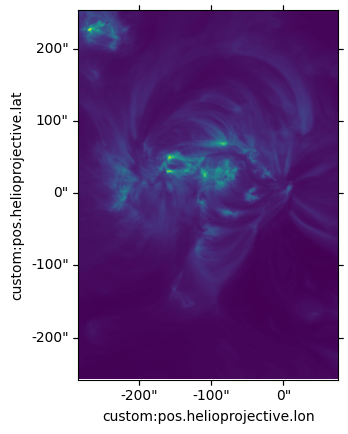

In [21]:
cube_from_zarr[0].plot()